**Firstly we need to check the use of GPU.** The reason why we will use mixed precision traning : Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory. Among NVIDIA GPUs(the ones offered by Google Colab), those with compute capability 7.0 or higher will see the greatest performance benefit from mixed precision because they have special hardware units, called Tensor Cores. If running this guide in Google Colab, the GPU runtime typically has a P100 connected. The P100 has compute capability 6.0 and is not expected to show a significant speedup. **So we need to have access to a GPU, with a compute capability at least 7.0.** That's we before using mixed precision training(to see its benefits), we get sure that we have access to a **TESLA T4**, provided by Google Colab. So not all the GPUs offered free by Google Colab are compatible with Mixed Precision Training such as: K80, P100 etc.
Link: https://www.tensorflow.org/guide/mixed_precision

If you're not using Google Colab, you can find a list of various Nvidia GPU compute capabilities on Nvidia's developer website https://developer.nvidia.com/cuda-gpus#compute.

In [ ]:
# If we couldn't use a TESLA T4, our code would run much slowlier
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f7ff7657-6c34-0ba2-150f-b68770d6af0b)


In [ ]:
# Now we need to create some helper functions, which will save us a whole bunch of code.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-06 16:07:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-06 16:07:21 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import some of the helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

Now we will download our data from the TensorFlow datasets: https://www.tensorflow.org/datasets/overview


In [ ]:
# Getting tensorflow datasets(advantage: data is already in tensor format)
import tensorflow_datasets as tfds

In [ ]:
# Listing all available datasets
datasets_list = tfds.list_builders()
# Is the dataset we want available?
print("food101" in datasets_list) 

True


In [ ]:
# Load in the data from the above dataset using the built-in function "tdfs.load()"
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # data get returned in tuple format (sample, label), e.g. (image, label) - keep the labels
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info) - it downloads not only the tensors and the respective labels, but also
                                             # the metadata and that's why we used "ds_info" variable


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ0UDP5/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteQ0UDP5/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Built-in function information: https://www.tensorflow.org/datasets/api_docs/python/tfds/load. We downloaded the dataset in our google colab instance not in our machine because we can avoid the second option, which is an advantage especially when working on a more than 5GB dataset.

In [ ]:
# Becoming one with the data, so get to know how are our data look like
# Using the built-in attribute "features" on the variable representing our metadata
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

So above we can clearly see that we are working on images, which have a certain shape(width, height, number of color codes). Image type is **tf.uint8** which we need to convert into the preferred type of neural networks. Secondly, we have our labels, which represent 101 classes. 

In [ ]:
# Getting first 5 class names using "names" attribute
class_names = ds_info.features["label"].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
# Taking one sample off the training data using the built-in method, "take()"
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Looping through our single training sample and getting some info from the image_tensor and label.
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (341, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 98
  Class name (str form): tiramisu
        


It looks like our labels are not hot encoded, because in that case they would be represented by arrays of 0 and 1, instead of an int value. 

In [ ]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]],

       [[227, 206, 139],
        [234, 213, 146],
        [238, 219, 153],
        ...,
        [117, 100,  70],
        [108,  91,  65],
        [101,  83,  59]],

       ...,

       [[ 35,   7,  19],
        [ 35,   7,  19],
        [ 36,   8,  20],
        ...,
        [198, 181, 127],
        [196, 179, 125],
        [193, 176, 122]],

       [[ 34,   6,  18],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [200, 183, 129],
        [201, 184, 130],
        [198, 181, 127]],

       [[ 33,   5,  17],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [203, 186, 13

Our data is also not normalized, so the values of the color channels are not between 0 and 1(how the neural networks prefer images to be input).We will fix this issue, while preprocessing our data. So, currently, we have values between 0 and 255, just like shown below:

In [ ]:
import tensorflow as tf
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

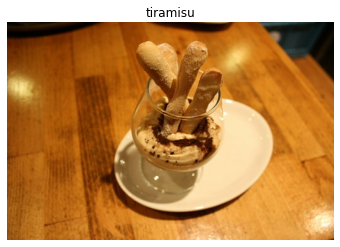

In [ ]:
# Plotting one of the image samples using matplotlib.pyplot.imshow() and setting the title to target class name.
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing the respective element on class_names list
plt.axis(False);

**Create preprocessing functions for our data**

Neural networks perform best when data is in a certain way(normalized, batched, etc.).
However not all the data(specifically data from TensorFlow datasets) is in this format. So in order to get ready for the neural network, we need the preprocessing functions map our data. 

**Our data is currently:**
- In uint8 data type
- Comprised of all differnet sized tensors (different sized images)
- Not scaled/normalized (the pixel values are between 0 & 255)

**Whereas, models like data to be:**
- In float32 data type
- Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
- Scaled (values between 0 & 1)

**As the base model we will use a pretrained *EfficientNetBX* model**. It also provides a rescaling layer built-in. Therefore we don't need to normalize our data when passing it to the model. The reason why we are using this specific model is because it has achieved quite high results in terms of image classification. 



In [ ]:
# Creating our preprocessing function which will:
# - resize/reshape an input image tensor to a specified size using tf.image.resize()
# - convert an input image tensor's current datatype to tf.float32 using tf.cast()
# It takes a label as an argument due to our data format(image, label)
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[239 217 157]
  [244 222 162]
  [247 227 168]
  ...
  [119 104  73]
  [111  95  70]
  [105  89  66]]

 [[233 212 149]
  [239 218 155]
  [243 223 162]
  ...
  [117 102  71]
  [108  92  67]
  [101  85  62]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[238.7704   217.41327  155.4847  ]
  [242.83673  222.83673  162.55101 ]
  [240.85713  220.20918  164.2143  ]
  ...
  [131.28564  118.28565   75.7806  ]
  [123.88257  109.81113   75.09689 ]
  [106.698746  90.698746  66.4131  ]]

 [[232.16325  212.09183  141.37755 ]
  [238.86224  219.86224  151.07654 ]
  [239.94388  221.08673  155.87245 ]
  ...
  [127.49998  112.49998   71.07145 ]
  [122.63767  106.56623   72.852   ]
  [105.83142   88.47424   63.1886  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


**Batch and prepare our dataset**
Creating performant(that will run fast) data pipelines with tensorflow.
https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training data (and paralellize)
# So the built-in "map()" method helps us to apply a certain function to all the samples of the training data
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# tf.data.AUTOTUNE automatically tunes the number of processors it uses, by deafault it will use only 1 process.
# So its aim is to use as many processors as it finds. It suggests to TensorFlow to use all the compute power it finds since
# we deal with an extremely large amount of data.

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
# We also shuffled the data when we downloaded our dataset but just to be safe we shuffle it again, so that
# our neural network doesn't learn any order. 
# "buffer_size" indicates the number of samples to get shuffled at the same time...ideally it should have been equal to 
# the total number of samples that comprise our dataset
# "batch_size" has a default value of 32 
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (no need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Create modelling callbacks**

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:

`tf.keras.callbacks.TensorBoard()` - allows us to keep track of our model's training history so we can inspect it later (note: we've created this callback before have imported it from helper_functions.py as `create_tensorboard_callback()`)

`tf.keras.callbacks.ModelCheckpoint()` - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" in our helper functions)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved 

**Setup mixed precision training**


In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 
# This tells TensorFlow to use mixed precision training for every part that it can do that.
# This in order to use up to 3x speedup on modern GPUs, thanks to a combination of float32 and float16 data types used by mixed precision training.

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
# Checking the global dtype policy (the policy which will be used by layers in our model) 
# using the mixed_precision.global_policy() method.
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

**Build feature extraction model**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3) # Here we can also use a global variable to determine our image shape
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # since we want to add our own output shape
base_model.trainable = False # freeze base model layers 

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in 
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Check out our model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

`layer.name` (str) : a layer's human-readable name, can be defined by the name parameter on construction

`layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False

`layer.dtype` : the data type a layer stores its variables in

`layer.dtype_policy` : the data type a layer computes in

In [ ]:
# Check the layers in the base model(EfficientNetB0) and see what dtype policy they're using
for layer in model.layers[1].layers[-20:]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

block6d_project_conv False float32 <Policy "mixed_float16">
block6d_project_bn False float32 <Policy "mixed_float16">
block6d_drop False float32 <Policy "mixed_float16">
block6d_add False float32 <Policy "mixed_float16">
block7a_expand_conv False float32 <Policy "mixed_float16">
block7a_expand_bn False float32 <Policy "mixed_float16">
block7a_expand_activation False float32 <Policy "mixed_float16">
block7a_dwconv False float32 <Policy "mixed_float16">
block7a_bn False float32 <Policy "mixed_float16">
block7a_activation False float32 <Policy "mixed_float16">
block7a_se_squeeze False float32 <Policy "mixed_float16">
block7a_se_reshape False float32 <Policy "mixed_float16">
block7a_se_reduce False float32 <Policy "mixed_float16">
block7a_se_expand False float32 <Policy "mixed_float16">
block7a_se_excite False float32 <Policy "mixed_float16">
block7a_project_conv False float32 <Policy "mixed_float16">
block7a_project_bn False float32 <Policy "mixed_float16">
top_conv False float32 <Policy 

**Loading the saved weights to our existing model**

In [ ]:
model.load_weights("model_checkpoints/cp.ckpt")

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
results_feature_extract_model_2 = model.evaluate(test_data)
results_feature_extract_model_2

790/790 [==============================] - 51s 64ms/step - loss: 1.0898 - accuracy: 0.7058


[1.0897670984268188, 0.7058217525482178]

In [ ]:
# How many layers has the base model?
len(model.layers[1].layers)

237

In [ ]:
len(base_model.layers)

237

In [ ]:
# start finetuning
base_model.trainable = True

In [ ]:
# freeze all layers of the base_model except for last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_3 False float32 <Policy "float32">
1 rescaling_2 False float32 <Policy "mixed_float16">
2 normalization_2 False float32 <Policy "mixed_float16">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Pol

In [ ]:
# So now the base model is trainable since it has 10 trainable layers.
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_layer True float32 <Policy "float32">
1 efficientnetb0 True float32 <Policy "mixed_float16">
2 pooling_layer True float32 <Policy "mixed_float16">
3 dense_2 True float32 <Policy "mixed_float16">
4 softmax_float32 True float32 <Policy "float32">


In [ ]:
# Recompile our model, since we need to do that every time that we make a change
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# check which layers are tunable/trainable:
for i, layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# check how many trainable variables has our model
print(len(model.trainable_variables))

12


In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=10, # should be enough for our top layers to adjust their weights enough to our food image data
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # to save time per epoch, we'll also only validate on 15% of the test data
                                                     initial_epoch=history_101_food_classes_feature_extract.epoch[-1],
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_fine_tune_last_10")])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune_last_10/20220606-185512
Epoch 3/10
2368/2368 [==============================] - 182s 73ms/step - loss: 0.9466 - accuracy: 0.7506 - val_loss: 0.9923 - val_accuracy: 0.7264
Epoch 4/10
2368/2368 [==============================] - 172s 72ms/step - loss: 0.8001 - accuracy: 0.7866 - val_loss: 0.9686 - val_accuracy: 0.7362
Epoch 5/10
2368/2368 [==============================] - 167s 70ms/step - loss: 0.6902 - accuracy: 0.8161 - val_loss: 0.9766 - val_accuracy: 0.7315
Epoch 6/10
2368/2368 [==============================] - 166s 70ms/step - loss: 0.5961 - accuracy: 0.8430 - val_loss: 0.9799 - val_accuracy: 0.7333
Epoch 7/10
2368/2368 [==============================] - 164s 69ms/step - loss: 0.5134 - accuracy: 0.8659 - val_loss: 0.9824 - val_accuracy: 0.7428
Epoch 8/10
2368/2368 [==============================] - 170s 71ms/step - loss: 0.4408 - accuracy: 0.8874 - val_loss: 1.0081 - val_accuracy: 0.7360
E

In [ ]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 51s 64ms/step - loss: 1.0512 - accuracy: 0.7350


[1.0511901378631592, 0.7349702715873718]

**------------------------------------------------------------------------------------------------------**

In [ ]:
# Now let's try fine tuning by setting all the layers to trainable
for layer in model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 True float32 <Policy "float32">
rescaling_2 True float32 <Policy "mixed_float16">
normalization_2 True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "m

**A couple more callbacks**

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune_all = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning_all_efundit"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning_all_efundit/20220606-193843
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4071 - accuracy: 0.8775INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 387s 158ms/step - loss: 0.4071 - accuracy: 0.8775 - val_loss: 1.0535 - val_accuracy: 0.7415 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 336s 141ms/step - loss: 0.2274 - accuracy: 0.9313 - val_loss: 1.0904 - val_accuracy: 0.7548 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9533
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 333s 140ms/step - loss: 0.1487 - accuracy: 0.9533 - val_loss: 1.2013 - val_accuracy: 0.7397 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 330s 139ms/step - loss: 0.0303 - accuracy: 0.9935 - val_loss: 1.2574 - val_accuracy: 0.7672 - lr: 2.0000e-05


In [ ]:
# Evaluate mixed precision trained loaded model
results_final = model.evaluate(test_data) 
results_final

790/790 [==============================] - 49s 62ms/step - loss: 1.2229 - accuracy: 0.7698


[1.2228742837905884, 0.7698217630386353]

**-------------------------------------------------------------------------------------------------**

**Fit the feature extraction model**

In [ ]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3, # should be enough for our top layers to adjust their weights enough to our food image data
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # to save time per epoch, we'll also only validate on 15% of the test data
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220606-161543
Epoch 1/3
2368/2368 [==============================] - 189s 72ms/step - loss: 1.8190 - accuracy: 0.5570 - val_loss: 1.2322 - val_accuracy: 0.6753
Epoch 2/3
2368/2368 [==============================] - 166s 70ms/step - loss: 1.2931 - accuracy: 0.6671 - val_loss: 1.1316 - val_accuracy: 0.6970
Epoch 3/3
2368/2368 [==============================] - 164s 69ms/step - loss: 1.1424 - accuracy: 0.7016 - val_loss: 1.0929 - val_accuracy: 0.7042


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 50s 63ms/step - loss: 1.0898 - accuracy: 0.7058


[1.0897669792175293, 0.7058217525482178]

Load and evaluate checkpoint weights

In [ ]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Where are our checkpoints stored?
checkpoint_path

'fine_tune_checkpoints/'

In [ ]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights("model_checkpoints/cp.ckpt")

In [ ]:
# Each time we make a change to your model (including loading weights), we have to recompile.
# Compiling cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
# Evaluating cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 51s 62ms/step - loss: 1.7431 - accuracy: 0.5425


Our cloned model with loaded weight's results should be very close to the feature extraction model's results.

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
np.allclose(results_feature_extract_model, results_cloned_model_with_loaded_weights) # check if all elements in array are close

False

**Preparing our model's layers for fine-tuning**

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-06-06 16:32:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  75.1MB/s    in 0.2s    

2022-06-06 16:32:26 (75.1 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of our downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 55s 65ms/step - loss: 1.0881 - accuracy: 0.7065


[1.088127613067627, 0.7064950466156006]

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220606-163640
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.7528INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 389s 157ms/step - loss: 0.9223 - accuracy: 0.7528 - val_loss: 0.7862 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.8399INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 368s 155ms/step - loss: 0.5776 - accuracy: 0.8399 - val_loss: 0.7791 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 335s 141ms/step - loss: 0.3315 - accuracy: 0.9061 - val_loss: 0.8421 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9483
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 336s 141ms/step - loss: 0.1749 - accuracy: 0.9483 - val_loss: 0.9619 - val_accuracy: 0.7820 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 332s 139ms/step - loss: 0.0349 - accuracy: 0.9922 - val_loss: 1.0659 - val_accuracy: 0.8040 - lr: 2.0000e-05


In [ ]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_gs_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 56s 70ms/step - loss: 1.0649 - accuracy: 0.7964


[1.0648876428604126, 0.7964356541633606]

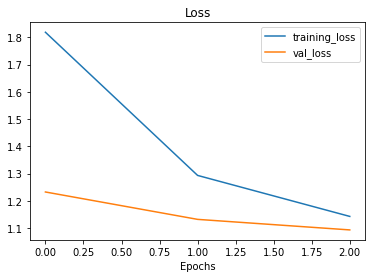

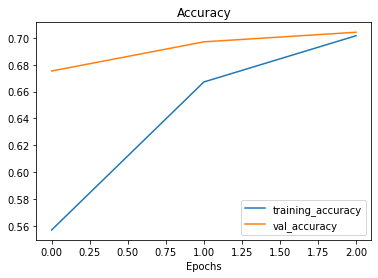

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)